**1、PG（Policy Gradient）算法回顾**

在PG算法中，我们的Agent又被称为Actor，Actor对于一个特定的任务，都有自己的一个策略π，策略π通常用一个神经网络表示，其参数为θ。从一个特定的状态state出发，一直到任务的结束，被称为一个完整的eposide，在每一步，我们都能获得一个奖励r，一个完整的任务所获得的最终奖励被称为R。这样，一个有T个时刻的eposide，Actor不断与环境交互，形成如下的序列τ：

![PG算法序列τ](images/PG算法序列τ.png)

这样一个序列τ是不确定的，因为Actor在不同state下所采取的action可能是不同的，一个序列τ发生的概率为：

$\begin{array}{l}p_\theta(\tau)\\ =p(s_1)p_\theta(a_1|s_1)p(s_2|s_1,a_1)p_\theta(a_2|s_2)p(s_3|s_2,a_2)\cdots\\ =p(s_1)\prod_{t=1}^T p_\theta(a_t|s_t)p(s_{t+1}|s_t,a_t)\\ \end{array}$

序列τ所获得的奖励为每个阶段所得到的奖励的和，称为R(τ)。因此，在Actor的策略为π的情况下，所能获得的期望奖励为：

$\bar{R}_\theta=\sum_\tau R(\tau)p_\theta(\tau)=E_{\tau\sim p_\theta(\tau)}[R(\tau)]$

而我们的期望是调整Actor的策略π，使得期望奖励最大化，于是我们有了策略梯度的方法，既然我们的期望函数已经有了，我们只要使用梯度提升的方法更新我们的网络参数θ（即更新策略π）就好了，所以问题的重点变为了求参数的梯度。梯度的求解过程如下：

![img](images/PG梯度求解.png)

上面的过程中，我们首先利用log函数求导的特点进行转化，随后用N次采样的平均值来近似期望，最后，我们将pθ展开，将与θ无关的项去掉，即得到了最终的结果。

所以，一个PG方法的完整过程如下：

![img](images/PG流程.png)

我们首先采集数据，然后基于前面得到的梯度提升的式子更新参数，随后再根据更新后的策略再采集数据，再更新参数，如此循环进行。注意到图中的大红字only used once，因为在更新参数后，我们的策略已经变了，而先前的数据是基于更新参数前的策略得到的。

**2、PPO算法原理简介**

PG方法一个很大的缺点就是参数更新慢，因为我们每更新一次参数都需要进行重新的采样，这其实是中on-policy的策略，即我们想要训练的agent和与环境进行交互的agent是同一个agent；与之对应的就是off-policy的策略，即想要训练的agent和与环境进行交互的agent不是同一个agent，简单来说，就是拿别人的经验来训练自己。举个打游戏的例子，如果你是通过自己玩竞技游戏来不断提升自己的水平，那么就是on-policy的，如果是通过看别人打游戏来学习经验，那么就是off-policy的。

那么为了提升我们的训练速度，让采样到的数据可以重复使用，我们可以将on-policy的方式转换为off-policy的方式。即我们的训练数据通过另一个Actor（对应的网络参数为θ'得到。这要怎么做呢？通过下面的思路：

![img](images/importance_sampling.png)

通过上述公式，我们可以认为两者的期望是相同的，但方差是否也相同呢？这里用到概率论中常用的公式，计算结果如下：

![importance sampling方差](images/importance_sampling方差.png)

所以问题就出现了，如果采样较少，importance sampling方法可能导致方差差异较大，通过这种方式，我们的p(x)和q(x)的分布不能差别太大，否则需要进行非常多次的采样，才能得到近似的结果，下图就是两者分布相差较大时出现的问题：

![img](images/importance sampling问题.png)

如上图所示，很显然，在x服从p(x)分布时，f(x)的期望为负，此时我们从q(x)中来采样少数的x，那么我们采样到的x很有可能都分布在右半部分，此时f(x)大于0，我们很容易得到f(x)的期望为正的结论，这就会出现问题，因此需要进行大量的采样。

那么此时我们想要期望奖励最大化，则变为，相较于之前的on-policy，现在变成了从$\theta'$进行采样，且多了$\frac{p_\theta}{p_\theta'}$项：

![off policy](images/off_policy.png)

则梯度变为：

![梯度更新](images/梯度更新.png)

最后一项因为我们假设两个分布不能差太远，所以认为他们是相等的，为了求解方便，我们直接划掉。此时似然函数变为：

![img](https:////upload-images.jianshu.io/upload_images/4155986-294137f7a57a5986.png?imageMogr2/auto-orient/strip|imageView2/2/w/621/format/webp)

由梯度变为似然函数，使用的还是这个式子：$\nabla f(x)=f(x)\nabla logf(x)$



到这里，我们马上就要得到我们的PPO算法了。

我们前面介绍了，我们希望θ和θ'不能差太远，这并不是说参数的值不能差太多，而是说，输入同样的state，网络得到的动作的概率分布不能差太远。得到动作的概率分布的相似程度，我们可以用KL散度来计算，将其加入PPO模型的似然函数中，变为：

![PPO](images/PPO.png)

在实际中，我们会动态改变对θ和θ'分布差异的惩罚，如果KL散度值太大，我们增加这一部分惩罚，如果小到一定值，我们就减小这一部分的惩罚，基于此，我们得到了PPO算法的过程：

![img](https:////upload-images.jianshu.io/upload_images/4155986-a31ebb78f4dc906a.png?imageMogr2/auto-orient/strip|imageView2/2/w/897/format/webp)

PPO的前身TRPO与PPO也是基本一致的，但是不像PPO直接把惩罚项直接放到需要优化的式子中，从而可以直接用梯度下降的方法去最大化这个式子，TRPO把KL散度当作一个constrain，希望$\theta$和$\theta'$的KL散度小于$\delta$，但这个在实现中较为困难。

![TRPO](images/TRPO.png)

PPO算法还有另一种实现方式，不将KL散度直接放入似然函数中，而是进行一定程度的裁剪：

![img](https:////upload-images.jianshu.io/upload_images/4155986-04610cbfc65b81aa.png?imageMogr2/auto-orient/strip|imageView2/2/w/927/format/webp)

上图中，绿色的线代表min中的第一项，即不做任何处理，蓝色的线为第二项，如果两个分布差距太大，则进行一定程度的裁剪。最后对这两项再取min，防止了θ更新太快。

PPT参考：https://speech.ee.ntu.edu.tw/~tlkagk/courses/MLDS_2018/Lecture/PPO%20(v3).pdf

**3、CartPole**

倒立摆问题是强化学习中的经典控制问题。Cartpole 是倒立摆问题中的一个离散控制任务。在游戏中有一个小车，上有竖着一根杆子。小车在一个光滑无摩擦的轨道上左右滑行，目的是使杆子保持竖直。如下图所示。
![cartpole](images/cartpole.gif)

Cartpole 的动作空间属于离散动作空间，有 2 个离散动作，分别是左移和右移。
- 左移 : 0 表示让 agent 向左移动。
- 右移 : 1 表示让 agent 向右移动。


Cartpole 的状态空间有 4 个元素，分别是：
- Cart Position ：小车的位置，范围是 [-4.8, 4.8] 。
- Cart Velocity ：小车的速度，范围是 [-inf, inf] 。
- Pole Angle ：杆的角度，范围是 [-24 deg, 24 deg] 。
- Pole Angular Velocity ：杆的角速度，范围是 [-inf, inf] 。

奖励空间

每一步操作，都将获得值为 1 的奖励，直到 episode 终止（终止状态也将获得值为 1 的奖励）。

终止条件

Cartpole 环境每个 episode 的终止条件是遇到以下任何一种情况：
- 杆偏移的角度超过 12 度。
- 小车出界，通常把边界距离设置为 2.4。
- 达到 episode 的最大 step，默认为 200。

Cartpole 任务在什么情况下视为胜利

当100次试验的平均 episode 奖励达到 195 以上时，视作游戏胜利。

In [1]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.step_n += 1
        if self.step_n >= 200:
            done = True
        return state, reward, done, info


env = MyWrapper()

env.reset()

array([ 0.00748571, -0.01096423,  0.01147898, -0.02036478], dtype=float32)

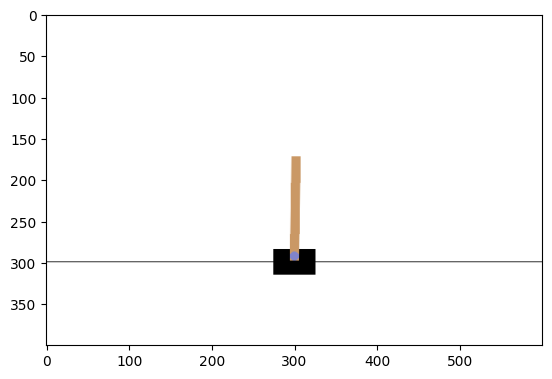

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline


# 打印游戏
def show():
    plt.imshow(env.render())
    plt.show()


show()

In [3]:
import torch

# 定义模型
model = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
    torch.nn.Softmax(dim=1),    # 希望模型输出结果是两个动作的概率分布
)

model_td = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1),    # 评价
)

model(torch.randn(2, 4)), model_td(torch.randn(2, 4))


c:\Users\saltyFish\anaconda3\envs\rl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(tensor([[0.5375, 0.4625],
         [0.5357, 0.4643]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.1332],
         [0.1797]], grad_fn=<AddmmBackward0>))

In [4]:
import random


# 得到一个动作
def get_action(state):
    state = torch.FloatTensor(state).reshape(1, 4)
    # [1, 4] -> [1, 2]
    prob = model(state)

    # 根据概率选择一个动作
    action = random.choices(range(2), weights=prob[0].tolist(), k=1)[0]

    return action


get_action([1, 2, 3, 4])


1

In [5]:
# 得到一局游戏的数据
def get_data():
    states = []
    rewards = []
    actions = []
    next_states = []
    overs = []

    # 初始化游戏
    state = env.reset()

    # 玩到游戏结束为止
    over = False
    while not over:
        # 根据当前状态得到一个动作
        action = get_action(state)

        # 执行动作,得到反馈
        next_state, reward, over, _ = env.step(action)

        # 记录数据样本
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        next_states.append(next_state)
        overs.append(over)

        # 更新游戏状态,开始下一个动作
        state = next_state

    #[b, 4]
    states = torch.FloatTensor(states).reshape(-1, 4)
    #[b, 1]
    rewards = torch.FloatTensor(rewards).reshape(-1, 1)
    #[b, 1]
    actions = torch.LongTensor(actions).reshape(-1, 1)
    #[b, 4]
    next_states = torch.FloatTensor(next_states).reshape(-1, 4)
    #[b, 1]
    overs = torch.LongTensor(overs).reshape(-1, 1)

    return states, rewards, actions, next_states, overs


get_data()


c:\Users\saltyFish\anaconda3\envs\rl\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)


(tensor([[-1.5443e-02, -3.1456e-02,  2.1062e-02,  3.8902e-02],
         [-1.6072e-02, -2.2687e-01,  2.1840e-02,  3.3816e-01],
         [-2.0609e-02, -3.2069e-02,  2.8604e-02,  5.2439e-02],
         [-2.1251e-02, -2.2759e-01,  2.9652e-02,  3.5401e-01],
         [-2.5802e-02, -3.2901e-02,  3.6732e-02,  7.0821e-02],
         [-2.6460e-02,  1.6168e-01,  3.8149e-02, -2.1005e-01],
         [-2.3227e-02,  3.5623e-01,  3.3948e-02, -4.9046e-01],
         [-1.6102e-02,  1.6065e-01,  2.4139e-02, -1.8727e-01],
         [-1.2889e-02, -3.4811e-02,  2.0393e-02,  1.1293e-01],
         [-1.3585e-02,  1.6001e-01,  2.2652e-02, -1.7325e-01],
         [-1.0385e-02, -3.5426e-02,  1.9187e-02,  1.2649e-01],
         [-1.1094e-02,  1.5942e-01,  2.1716e-02, -1.6008e-01],
         [-7.9054e-03,  3.5422e-01,  1.8515e-02, -4.4584e-01],
         [-8.2103e-04,  1.5884e-01,  9.5981e-03, -1.4737e-01],
         [ 2.3558e-03, -3.6417e-02,  6.6506e-03,  1.4832e-01],
         [ 1.6275e-03, -2.3163e-01,  9.6170e-03,  4.431

In [6]:
from IPython import display


def test(play):
    # 初始化游戏
    state = env.reset()

    # 记录反馈值的和,这个值越大越好
    reward_sum = 0

    # 玩到游戏结束为止
    over = False
    while not over:
        # 根据当前状态得到一个动作
        action = get_action(state)

        # 执行动作,得到反馈
        state, reward, over, _ = env.step(action)
        reward_sum += reward

        # 打印动画
        if play and random.random() < 0.2:  # 跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)


33.0

In [7]:
#优势函数
def get_advantages(deltas):
    advantages = []

    #反向遍历deltas
    s = 0.0
    for delta in deltas[::-1]:
        s = 0.98 * 0.95 * s + delta
        advantages.append(s)

    #逆序
    advantages.reverse()
    return advantages


get_advantages(range(5))

[8.090483997483998, 8.690100963999999, 8.260044, 6.724, 4.0]

In [8]:
def train():
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    optimizer_td = torch.optim.Adam(model_td.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()

    # 玩N局游戏,每局游戏训练M次
    for epoch in range(501):
        # 玩一局游戏,得到数据
        # states -> [b, 4]
        # rewards -> [b, 1]
        # actions -> [b, 1]
        # next_states -> [b, 4]
        # overs -> [b, 1]
        states, rewards, actions, next_states, overs = get_data()

        # 计算values和targets
        # [b, 4] -> [b, 1]
        values = model_td(states)

        # [b, 4] -> [b, 1]
        targets = model_td(next_states).detach()
        targets = targets * 0.98
        targets *= (1 - overs)
        targets += rewards

        # 计算优势,这里的advantages有点像是策略梯度里的reward_sum
        # 只是这里计算的不是reward,而是target和value的差
        # [b, 1]
        deltas = (targets - values).squeeze(dim=1).tolist()
        advantages = get_advantages(deltas)
        advantages = torch.FloatTensor(advantages).reshape(-1, 1)

        # 取出每一步动作的概率
        # [b, 2] -> [b, 2] -> [b, 1]
        old_probs = model(states)
        old_probs = old_probs.gather(dim=1, index=actions)
        old_probs = old_probs.detach()

        # 每批数据反复训练10次
        for _ in range(10):
            # 重新计算每一步动作的概率
            # [b, 4] -> [b, 2]
            new_probs = model(states)
            # [b, 2] -> [b, 1]
            new_probs = new_probs.gather(dim=1, index=actions)
            # new_probs = new_probs

            # 求出概率的变化
            # [b, 1] - [b, 1] -> [b, 1]
            ratios = new_probs / old_probs

            # 计算截断的和不截断的两份loss,取其中小的
            # [b, 1] * [b, 1] -> [b, 1]
            surr1 = ratios * advantages
            # [b, 1] * [b, 1] -> [b, 1]
            surr2 = torch.clamp(ratios, 0.8, 1.2) * advantages

            loss = -torch.min(surr1, surr2)
            loss = loss.mean()

            # 重新计算value,并计算时序差分loss
            values = model_td(states)
            loss_td = loss_fn(values, targets)

            # 更新参数
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            optimizer_td.zero_grad()
            loss_td.backward()
            optimizer_td.step()

        if epoch % 50 == 0:
            test_result = sum([test(play=False) for _ in range(10)]) / 10
            print(epoch, test_result)


train()


0 21.6
50 199.3
100 193.9
150 195.6
200 197.3
250 200.0
300 188.0
350 200.0
400 200.0
450 200.0
500 200.0


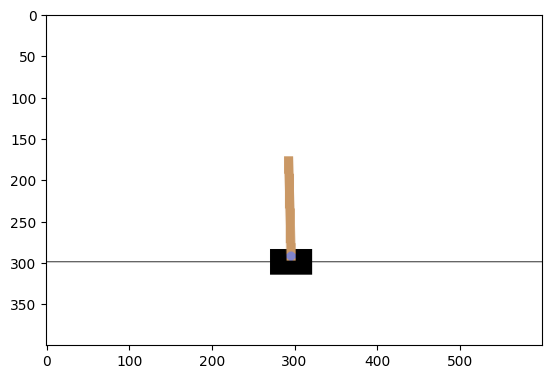

200.0

In [9]:
test(play=True)